In [1]:
import numpy as np
import scipy.linalg as la
from scipy.fftpack import fft
import matplotlib.pyplot as plt
%matplotlib inline
# try to load a local style sheet for matplotlib
# see http://matplotlib.org/users/style_sheets.html
try:
    plt.style.use('presentation')
except:
    pass # do nothing if it cannot be found

# Clenshaw-Curtis-Quadratur

_Andreas Potschka_

Schon im Jahr 1960 wurde von Clenshaw und Curtis eine Quadraturregel publiziert, die erst in den 2000er Jahren populär wurde. Wir wollen hier kurz das Prinzip beschreiben. 

Die Quadraturregel von Clenshaw und Curtis basiert auf einer Entwicklung der zu integrierenden Funktion $f: [-1, 1] \to \mathbb{R}$ in Tschebytschow-Polynomen $\{T_0, T_1, \dotsc\}$ (analog zu einer Taylor-Entwicklung um 0 in der Monombasis $\{1, x, x^2, \dotsc\}$).

## Tschebytschow-Entwicklung

Zur Erinnerung: Die Tschebytschow-Polynome können aus der Monombasis gewonnen werden durch Gram-Schmidt-Orthogonalisierung (mit Normierung $T_k(1) = 1$) bezüglich des Skalarproduktes

$$(f, g)_\omega = \int_{-1}^1 f(x) g(x) \omega(x) dx, \quad \text{mit } \omega(x) = \frac{1}{\sqrt{1 - x^2}}.$$

Sie haben die Darstellung $T_k(x) = \cos(k \arccos(x))$ und genügen der Dreitermrekursion

$$T_0(x) = 1, \quad T_1(x) = x, \quad T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x).$$

Man kann zeigen, dass jede Lipschitz-stetige Funktion $f: [-1, 1] \to \mathbb{R}$ eine absolut und uniform konvergente Tschebytschow-Entwicklung

$$f(x) = \sum_{k=0}^\infty a_k T_k(x)$$

zulässt. Der entscheidende Trick besteht nun in einer Variablentransformation $x = \cos(\theta)$. Damit ist $f(\cos(\theta))$ eine $2\pi$-periodische Funktion und die Tschebytschow-Entwicklung wegen $\arccos(x) = \theta$ ihre trigonometrische Entwicklung

$$f(\cos(\theta)) = \sum_{k=0}^\infty a_k \cos(k \theta),$$

die man effizient durch schnelle Fourier-Transformation (fast Fourier transformation, FFT) berechnen kann. Wertet man $f(\cos(\theta))$ auf $n+1$ äquidistanten Punkten $\theta_i \in (-\pi, \pi]$ aus, wobei man zudem $\cos(-\theta) = \cos(\theta)$ ausnutzen kann, so kann bekommt man gute Approximationen an $a_0, \dotsc, a_n$. Damit ergeben sich als Stützstellen für die Quadratur gerade die Tschebytschow-Punkte $x_i = \cos(\pi i/n)$, $i = 0, \dotsc, n$. Die Quadraturgewichte berechnet man nicht explizit. Vielmehr nimmt man die bei $k=n$ abgebrochene Tschebytschow-Entwicklung und erhält

$$\int_{-1}^1 f(x) dx \approx \sum_{k=0}^n a_k \int_{-1}^1 T_k(x) dx.$$ 

Die Integrale über die Tschebytschow-Polynome kann man für $k > 1$ mittels Variablentransformation explizit berechenen
$$\tilde{w}_k := \int_{-1}^1 T_k(x) dx = \int_{0}^{\pi} T_k(\cos(\theta)) \sin(\theta) d\theta = \int_0^{\pi} \cos(k\theta) \sin(\theta) d\theta = \frac{1 + (-1)^k}{1 - k^2}.$$

Das Integral approximiert man schließlich über die Formel

$$\int_{-1}^1 f(x) dx \approx \sum_{k=0}^n \tilde{w}_k a_k.$$

## Clenshaw-Curtis- und Gauß-Quadratur in Python

In Python kann man die Clenschaw-Curtis-Quadratur in weniger als 10 Zeilen programmieren:

In [2]:
def clenshaw_curtis(f, n):
    k = np.arange(n + 1.0)
    x = np.cos(np.pi * k / n) # Chebyshev points
    fx = f(x) / (2*n) # evaluate integrand
    g = fft(np.concatenate((fx, fx[-2:0:-1]))).real # fast Fourier transform
    a = np.concatenate(([g[0]], g[1:n] + g[2*n-1:n:-1], [g[n]])) # Chebyshev coefficients
    w = np.zeros(a.shape[0]) # set up weights
    w[0::2] = 2.0 / (1-np.arange(0, n+1, 2)**2)
    return w.dot(a)

Zum Vergleich geben wir hier eine ähnlich kurze Implementation der Gauß-Quadratur an, die auf einem Algorithmus von Golub und Welsch aus dem Jahr 1969 zurückgeht. Sie nutzt aus, dass man die Legendre-Punkte als Eigenwerte einer speziell gewählten Tridiagonalmatrix darstellen kann. Die Gauß-Quadraturgewichte lassen sich an den zugehörigen Eigenvektoren ablesen. Hinweise: Es gibt auch effizientere Algorithmen zur Berechnung der Gauß-Quadraturgewichte und -stützstellen.

In [3]:
def gauss(f, n):
    k = np.arange(1.0, n + 1.0)
    beta = 0.5 / np.sqrt(1 - (2*k)**(-2)) # 3-term recurrence coeffs
    T = np.zeros((2,n+1)) # set up Jacobi matrix with 0 diagonal
    T[1,:-1] = beta # and beta on secondary diagonals
    E, V = la.eig_banded(T, lower=True) # compute eigenvalues and eigenvectors
    perm = np.argsort(E) # sort eigenvalues
    x = E[perm] # get nodes (= Legendre points)
    w = 2 * V[0,perm]**2 # get quadrature weights
    return w.dot(f(x))

## Ordnung der Quadraturformeln

Wir überprüfen kurz die Ordnung der zwei Quadraturformeln, indem wir das Polynom $f(x) = (1+x) x^{20} \in P_{21}[-1, 1]$ integrieren. Das Polynom verläuft so:

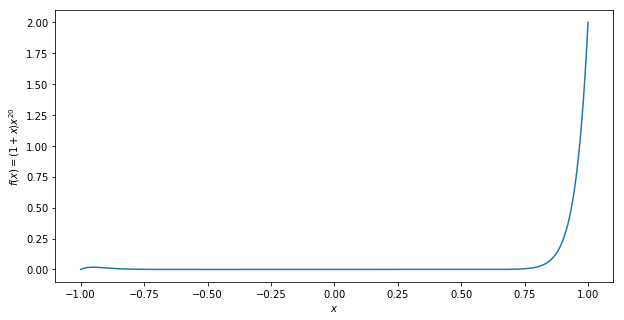

In [4]:
def f(x): return (1+x) * x**20
x = np.linspace(-1, 1, 1001)
plt.figure(figsize=(10,5))
plt.plot(x, f(x))
plt.xlabel('$x$')
plt.ylabel('$f(x) = (1+x)x^{20}$')
plt.show()

Wir benutzen nun die zwei Quadraturformeln für verschiedene Anzahlen an Stützstellen $n = 0, \dotsc, 25$ und plotten im Anschluss den Fehler.

In [5]:
N = 26
list_of_n = range(1, N)
I_gauss = np.empty(N)
I_clencurt = np.empty(N)
for n in list_of_n:
    I_gauss[n] = gauss(f, n)
    I_clencurt[n] = clenshaw_curtis(f, n)
I = gauss(f, 2*N)

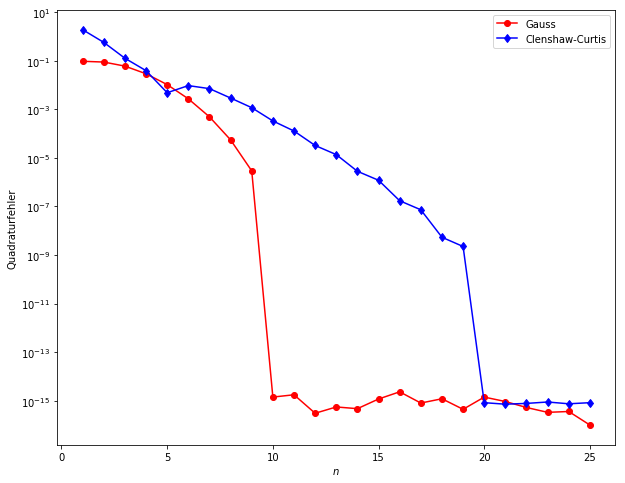

In [6]:
plt.figure(figsize=(10,8))
err_gauss = np.maximum(1e-16, abs(I_gauss[list_of_n] - I))
err_clencurt = np.maximum(1e-16, abs(I_clencurt[list_of_n] - I))
plt.semilogy(list_of_n, err_gauss, 'ro-')
plt.semilogy(list_of_n, err_clencurt, 'bd-')
plt.xlabel('$n$')
plt.ylabel('Quadraturfehler')
plt.legend(('Gauss', 'Clenshaw-Curtis'))
plt.show()

Wir können schön beobachten, dass die Gauß-Quadratur wie erwartet von der optimalen Ordnung $2n+2$ ist, wohingegen Clenshaw-Curtis-Quadratur nur die Ordnung $n+1$ erreicht. Dies ist der Grund, warum die Clenshaw-Curtis-Quadratur lange Zeit in deutlich schlechterem Ruf stand als die Gauß-Quadratur.

## Verhalten auf nicht-polynomiellen Funktionen

Wir betrachten nun ein komplizierteres, nichtpolynomielles Beispiel

$$f(x) = \left(\frac{\exp(x)}{\cosh(4 \sin(40 x))}\right)^{\exp(x)}.$$

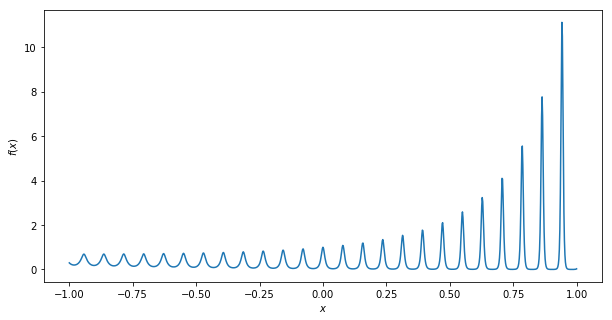

In [7]:
def f(x): return (np.exp(x) / np.cosh(4 * np.sin(40 * x)))**np.exp(x)
x = np.linspace(-1, 1, 1001)
plt.figure(figsize=(10,5))
plt.plot(x, f(x))
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

Wir vergleichen wiederum für wachsendes $n$, wie sich der Fehler der zwei Quadraturformeln verhält.

In [8]:
N = 1601
list_of_n = range(50, N, 50)
I_gauss = np.empty(N)
I_clencurt = np.empty(N)

print('Gauss:')
for n in list_of_n:
    print(n, end=' ', flush=True)
    I_gauss[n] = gauss(f, n)

print('\nClenshaw-Curtis:')
for n in list_of_n:
    print(n, end=' ', flush=True)
    I_clencurt[n] = clenshaw_curtis(f, n)

I = gauss(f, 2*N)    

Gauss:
50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 
Clenshaw-Curtis:
50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 

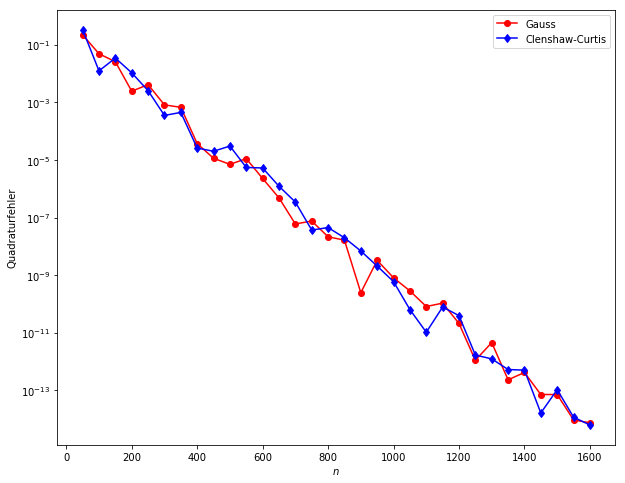

In [9]:
plt.figure(figsize=(10,8))
err_gauss = np.maximum(1e-16, abs(I_gauss[list_of_n] - I))
err_clencurt = np.maximum(1e-16, abs(I_clencurt[list_of_n] - I))
plt.semilogy(list_of_n, err_gauss, 'ro-')
plt.semilogy(list_of_n, err_clencurt, 'bd-')
plt.xlabel('$n$')
plt.ylabel('Quadraturfehler')
plt.legend(('Gauss', 'Clenshaw-Curtis'))
plt.show()

Offensichtlich schneidet hier die Clenshaw-Curtis-Quadratur genauso gut oder schlecht ab, wie die Ordnungs-optimale Gauß-Quadratur. 

## Ein Vorteil der Clenshaw-Curtis-Quadratur

Im Vergleich zur Gauß-Quadratur hat die Clenshaw-Curtis-Quadratur aber einen großen Vorteil, wenn $n$ adaptiv gewählt werden soll: Aufgrund der Natur der Tschebytschow-Punkte kann bei der Verdopplung von $n$ die Clenshaw-Curtis-Quadratur zu $2n+1$ Stützstellen alle Funktionswerte der Quadraturformel auf $n+1$ Stützstellen wiederverwenden. Dies ist bei der Gauß-Quadratur nicht möglich und erschwert eine adaptive Anwendung.

## Referenzen

- C. W. Clenshaw and A. R. Curtis, A method for numerical integration on an automatic computer, Numer. Math. 2 (1960), 197–205.
- G. H. Golub and J. H. Welsch, Calculation of Gauss quadrature rules, Math. Comp. 23 (1969), 221–230
- [Trefethen, Lloyd N. "Is Gauss Quadrature Better than Clenshaw–Curtis?" SIAM review 50, no. 1 (2008): 67-87.](http://eprints.maths.ox.ac.uk/1116/1/NA-06-07.pdf)
- [Chebfun, Approximation Theory and Practice](http://www.chebfun.org/ATAP/)